In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bax-gru/df_bax_cleaned_till_outliers.csv


2025-08-12 07:45:35.413192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754984735.579033      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754984735.628957      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


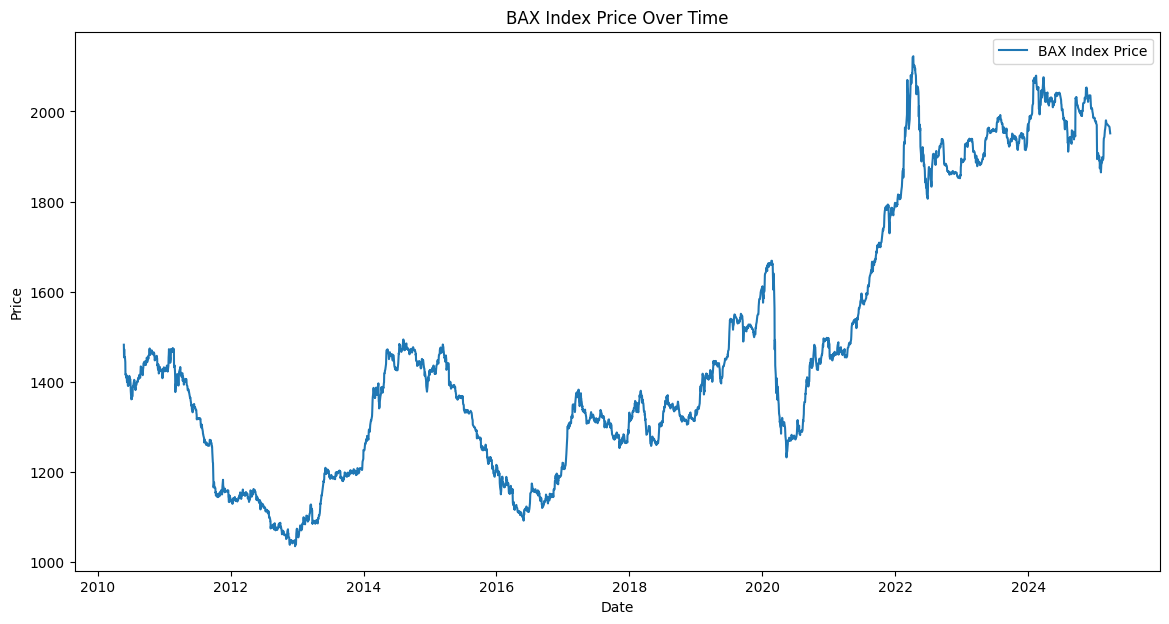

In [2]:
# Setup and Data Loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Load the dataset
df = pd.read_csv('/kaggle/input/bax-gru/df_bax_cleaned_till_outliers.csv')
df = pd.DataFrame(df)


# Convert 'Date' column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# We will use the 'Price' column for prediction
data = df['Price'].values.reshape(-1, 1)

plt.figure(figsize=(14, 7))
plt.plot(df.index, data, label='BAX Index Price')
plt.title('BAX Index Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [3]:
# Data Preparation for GRU

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create training data (80% of the data)
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

# Create the training data set
X_train = []
y_train = []

# We'll use a time step of 60 days
time_step = 60

for i in range(time_step, len(train_data)):
    X_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data for the GRU model [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

I0000 00:00:1754984747.277219      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


I0000 00:00:1754984752.527815      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0144
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.4639e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.7855e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.0793e-04
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.4487e-04
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.3355e-04
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.3314e-04
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.1959e-04
Epoch 12/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.6284e-04
Epoch 13/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5310e-04
Epoch 14/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.2012e-04
Epoch 15/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 

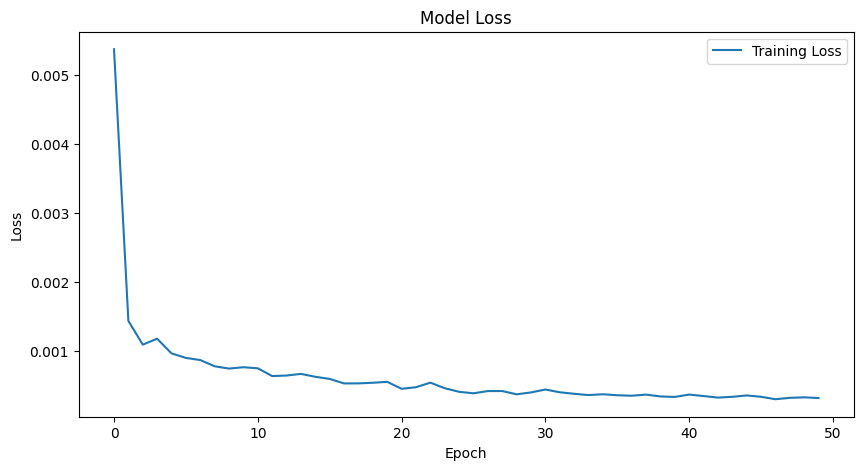

In [4]:
# Building the GRU Model

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1)) # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/tmp/ipykernel_36/1507498812.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


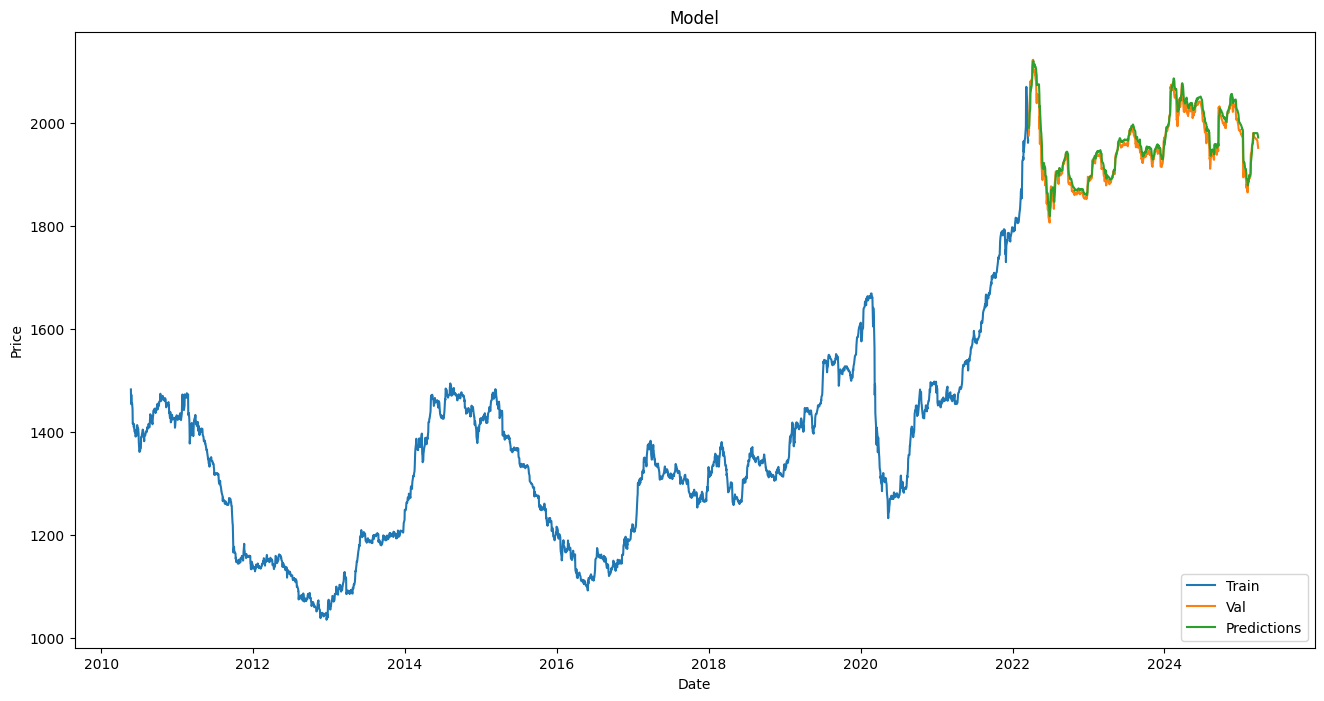

              Price  Predictions
Date                            
2022-03-20  1975.56  1990.363770
2022-03-21  1982.87  1992.399414
2022-03-22  2003.83  1994.554321
2022-03-23  2025.28  2004.623291
2022-03-24  2032.82  2018.971313


In [5]:
# Testing the Model

# Create the testing data set
test_data = scaled_data[training_data_len - time_step:, :]
X_test = []
y_test = data[training_data_len:, :]

for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i, 0])

# Convert to numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) # Unscale the values

# Plot the results
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Show the validation and predicted prices
print(valid[['Price', 'Predictions']].head())

In [6]:
from sklearn.metrics import mean_squared_error

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 15.175236683538602


In [7]:
# We need the last 60 days from the original dataset to predict the next day
last_60_days = data[-60:]

# Scale this data just like we did before
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list and append the scaled 60 days
X_future = []
X_future.append(last_60_days_scaled)

# Convert to a numpy array and reshape it for the model
X_future = np.array(X_future)
X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

# Get the predicted scaled price
predicted_price_scaled = model.predict(X_future)

# Undo the scaling to get the actual predicted price
predicted_price = scaler.inverse_transform(predicted_price_scaled)

print("Predicted price for the next day:", predicted_price[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted price for the next day: 1966.7031
